In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [4]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 10

In [5]:
# Define transformations: resizing, normalization, and any other preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize the image to the specified size
    transforms.ToTensor(),                   # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [6]:
# Create dataset
dataset = datasets.ImageFolder(root='../data/casting_data/casting_data/train', transform=transform)

# Create data loader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Get the class names from the dataset
class_names = dataset.classes
n_classes = len(class_names)
# Print class names
print(class_names)

['def_front', 'ok_front']


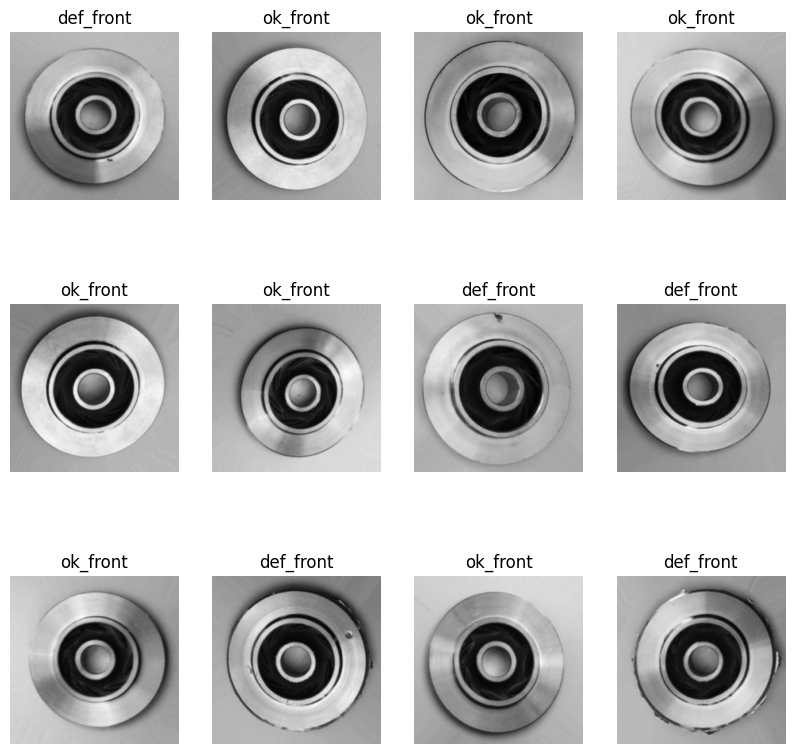

In [8]:
import matplotlib.pyplot as plt

# Mean and std used in normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    """Denormalize the image tensor to [0, 1] range for visualization."""
    img_tensor = img_tensor * std[:, None, None] + mean[:, None, None]  # Reverse the normalization
    return img_tensor

# Get a batch of data
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Plot the images
plt.figure(figsize=(10, 10))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    
    # Denormalize the image for correct visualization
    img = denormalize(images[i])
    img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    
    plt.imshow(img.numpy().clip(0, 1))  # Clip values to [0, 1] range
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.show()


In [9]:
from torch.utils.data import random_split

# Define the split ratio (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, validate_dataset = random_split(dataset, [train_size, val_size])

In [10]:
# Set the number of workers (for parallel data loading)
NUM_WORKERS = 8  

# Create DataLoader for training dataset with shuffling and parallel loading (prefetch-like)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

# Create DataLoader for validation dataset without shuffling (as validation/test sets typically aren't shuffled)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, n_classes):
        super(CNNModel, self).__init__()
        
        self.data_augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=20),
            transforms.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
            transforms.ColorJitter(contrast=0.2),
        ])
        
        self.conv1 = nn.Conv2d(in_channels=CHANNEL, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 14 * 14, 64)  # Adjusted based on pooling
        self.fc2 = nn.Linear(64, n_classes)
        
    def forward(self, x):

        # Apply data augmentation (only during training)
        if self.training:
            x = self.data_augmentation(x)

        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Create model instance
model = CNNModel(n_classes)


In [35]:
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=25088, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [36]:
import torch.optim as optim

# Instantiate the model
model = CNNModel(n_classes)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Define the loss function
criterion = nn.CrossEntropyLoss()  # This combines softmax and negative log likelihood loss

In [39]:
validate_accuracies = []
training_accuracies = []
# Ensure the model is moved to GPU before initializing the optimizer
model.to(device)  # Move model to GPU
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Initialize optimizer

for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU
        
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass

        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predictions
        total += labels.size(0)  # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions
    
    # Calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    training_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for val_images, val_labels in validate_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move to GPU
            
            val_outputs = model(val_images)  # Forward pass for validation
            loss = criterion(val_outputs, val_labels)  # Compute loss
            
            val_loss += loss.item()  # Accumulate validation loss
            _, val_predicted = torch.max(val_outputs.data, 1)  # Get predictions
            val_total += val_labels.size(0)  # Total validation samples
            val_correct += (val_predicted == val_labels).sum().item()  # Correct validation predictions
    
    # Calculate validation loss and accuracy
    val_loss /= len(validate_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    validate_accuracies.append(val_accuracy)


Epoch [1/10], Train Loss: 0.3919, Train Accuracy: 82.21%
Validation Loss: 6.8650, Validation Accuracy: 51.85%
Epoch [2/10], Train Loss: 0.3286, Train Accuracy: 84.43%
Validation Loss: 12.3418, Validation Accuracy: 48.83%
Epoch [3/10], Train Loss: 0.2567, Train Accuracy: 88.50%
Validation Loss: 15.3701, Validation Accuracy: 48.30%
Epoch [4/10], Train Loss: 0.2058, Train Accuracy: 91.73%
Validation Loss: 11.5804, Validation Accuracy: 56.90%
Epoch [5/10], Train Loss: 0.1887, Train Accuracy: 92.29%
Validation Loss: 12.5126, Validation Accuracy: 60.14%
Epoch [6/10], Train Loss: 0.1812, Train Accuracy: 93.08%
Validation Loss: 26.8358, Validation Accuracy: 50.11%
Epoch [7/10], Train Loss: 0.1655, Train Accuracy: 93.29%
Validation Loss: 16.6815, Validation Accuracy: 60.81%
Epoch [8/10], Train Loss: 0.1357, Train Accuracy: 94.74%
Validation Loss: 11.7913, Validation Accuracy: 66.84%
Epoch [9/10], Train Loss: 0.1233, Train Accuracy: 95.23%
Validation Loss: 25.6723, Validation Accuracy: 55.69%
Ep

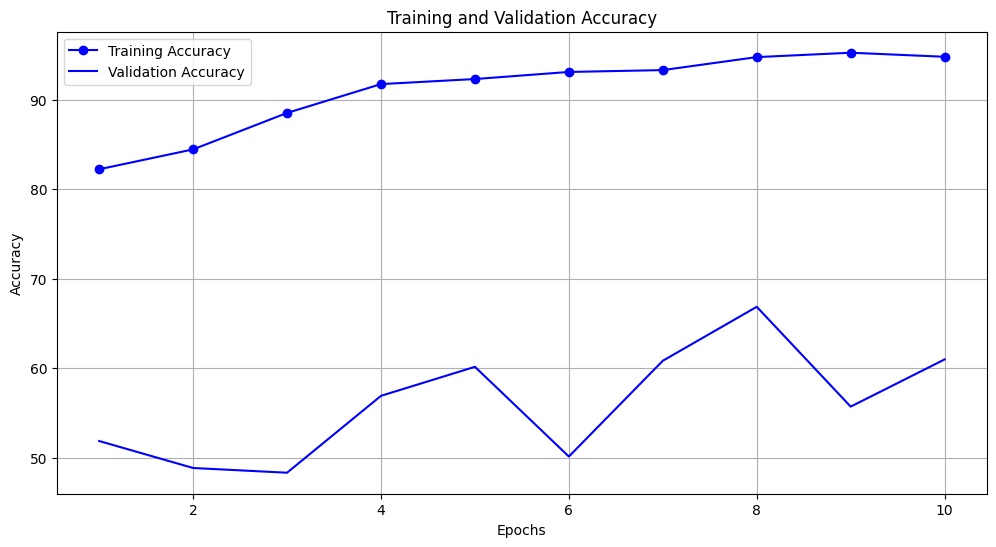

In [42]:
epochs = range(1, num_epochs + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_accuracies, 'bo-', label='Training Accuracy')  # 'bo-' for blue dots and line
plt.plot(epochs, validate_accuracies, 'b-', label='Validation Accuracy')  # 'b-' for solid blue line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Load the test dataset
test_dataset = datasets.ImageFolder(
    root="../data/casting_data/casting_data/test",  # Path to your test dataset
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [44]:
# Set the model to evaluation mode
model.eval()  
test_loss = 0.0
test_correct = 0
test_total = 0

# Disable gradient calculation for validation
with torch.no_grad():  
    for test_images, test_labels in test_loader:
        # Move images and labels to the appropriate device
        test_images, test_labels = test_images.to(device), test_labels.to(device)  
        
        # Forward pass for validation
        test_outputs = model(test_images)  
        
        # Compute loss
        loss = criterion(test_outputs, test_labels)  
        
        # Accumulate test loss
        test_loss += loss.item()  
        
        # Get predictions
        _, test_predicted = torch.max(test_outputs.data, 1)  
        
        # Total test samples
        test_total += test_labels.size(0)  
        
        # Correct test predictions
        test_correct += (test_predicted == test_labels).sum().item()  

# Calculate test loss and accuracy
test_loss /= len(test_loader)  # Average test loss
test_accuracy = 100 * test_correct / test_total  # Test accuracy

# Print results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 30.5662, Test Accuracy: 53.57%


In [45]:
# Save the entire model
torch.save(model, 'model.pth')